# Tornado Damage Assessment using Computer Vision

Description

## Setting up and Data Loading

In [36]:
# The two imports data science lives on
import pandas as pd 
import numpy as np

# Torch Things
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import torchvision
from torchinfo import summary
from torch import optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.utils import make_grid

# Visual/Image Things
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from glob import glob

# Misc.
import os

# Define Device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
efscale_mapping = {0: "EF0", 1: "EF1", 2: "EF2", 3: "EF3", 4: "EF4", 5: "EF5"}


In [ ]:
class TornadoDataset(Dataset):
    def __init__(self, df, img_dir):
        self.fpath = pd.read_csv(df)
        self.img_dir = img_dir
        self.transform = gray_transform

    def __len__(self):
        return len(self.fpath)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.fpath.iloc[idx]['image'])
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel images
        target = self.fpath.iloc[idx]['efscale']  # EF Scale label (0-5)

        if self.transform:
            image = self.transform(image)

        return image,torch.tensor(target, dtype=torch.long)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((250, 300)),  # Resize for CNN input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    
])

gray_transform = transforms.Compose([
    transforms.Resize((250, 300)),  # Resize for CNN input
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    
])

# Create dataset and dataloader
dataset = TornadoDataset(df="images.csv", img_dir="Images")

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Test the dataloader
#images, labels = next(iter(data_loader))
#print(images.shape, labels.shape)

# def imshow(img):
#     img = img / 2 + 0.5    
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# plt.figure(figsize=(60, 50))
# imshow(make_grid(images))

#print(' '.join(f'{efscale_mapping[labels[j].item()]:5s}' for j in range(32)))



In [ ]:
class_counts = df['efscale'].value_counts().sort_index()
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)

# Map the class weights based on 'efscale' values and convert to float32
sample_weights = df['efscale'].apply(lambda x: class_weights[x]).astype(np.float32).values

# Convert sample weights to a tensor
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

from torch.utils.data import WeightedRandomSampler

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [217]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
def get_data():
    full_dataset = TornadoDataset(df="images.csv", img_dir="Images")

    # Get labels for stratified splitting
    labels = [item[1] for item in full_dataset]  # Assuming item[1] is the label in your dataset

    # Stratified splitting
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Split dataset indices into train and val indices
    for train_indices, val_indices in sss.split(np.zeros(len(labels)), labels):
        train_subset = Subset(full_dataset, train_indices)
        val_subset = Subset(full_dataset, val_indices)

    # Create DataLoader for train and validation sets
    trn_dl = DataLoader(train_subset, batch_size=32, drop_last=True)
    val_dl = DataLoader(val_subset, batch_size=32, drop_last=True)

    return trn_dl, val_dl

## Get Data for modeling

In [ ]:
trn_dl, val_dl = get_data()

In [220]:
from collections import Counter

# Initialize a list to store labels
labels = []

# Iterate over the dataset and collect labels
for _, label in val_dl.dataset:
    labels.append(label.item())  # Assuming label is a tensor, you can use .item() to extract the value

# Count occurrences of each class
label_counts = Counter(labels)

# Print the counts for each class
for label, count in label_counts.items():
    print(f"Class {label}: {count} samples")

Class 1: 25 samples
Class 3: 10 samples
Class 0: 14 samples
Class 2: 7 samples


In [221]:
from collections import Counter

# Initialize a list to store labels
labels = []

# Iterate over the dataset and collect labels
for _, label in trn_dl.dataset:
    labels.append(label.item())  # Assuming label is a tensor, you can use .item() to extract the value

# Count occurrences of each class
label_counts = Counter(labels)

# Print the counts for each class
for label, count in label_counts.items():
    print(f"Class {label}: {count} samples")

Class 1: 101 samples
Class 2: 27 samples
Class 0: 55 samples
Class 3: 40 samples


## Initial Modeling

#### Model Creation

In [218]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),  # 1 input channel (grayscale image)
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(128 * 61 * 73, 256),  # Corrected input size after convolutions and pooling
        nn.ReLU(),
        nn.Linear(256, 4) 
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()


model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.append(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(np.array(val_is_correct, dtype=int))

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


### Evaluation

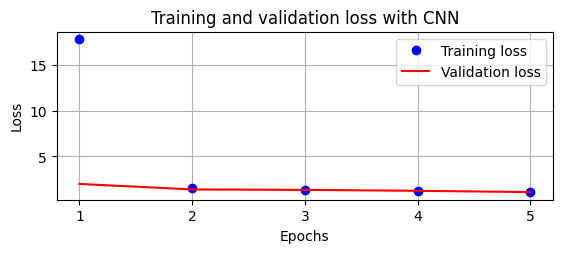

C:\Users\nicol\AppData\Local\Temp\ipykernel_68636\1600048630.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


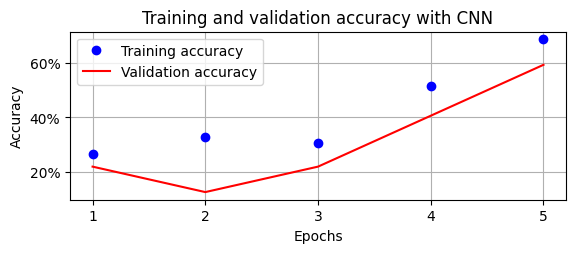

In [219]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

### CAM's

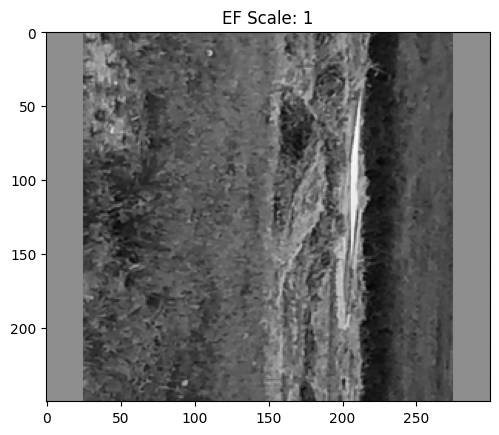

In [250]:
im, c = val_dl.dataset[19]
im = im / 255.
im_r= transforms.functional.rotate(im, -90)
plt.title(f"EF Scale: {c}")
plt.imshow(im_r.squeeze(0).cpu(), cmap='gray')
plt.show()

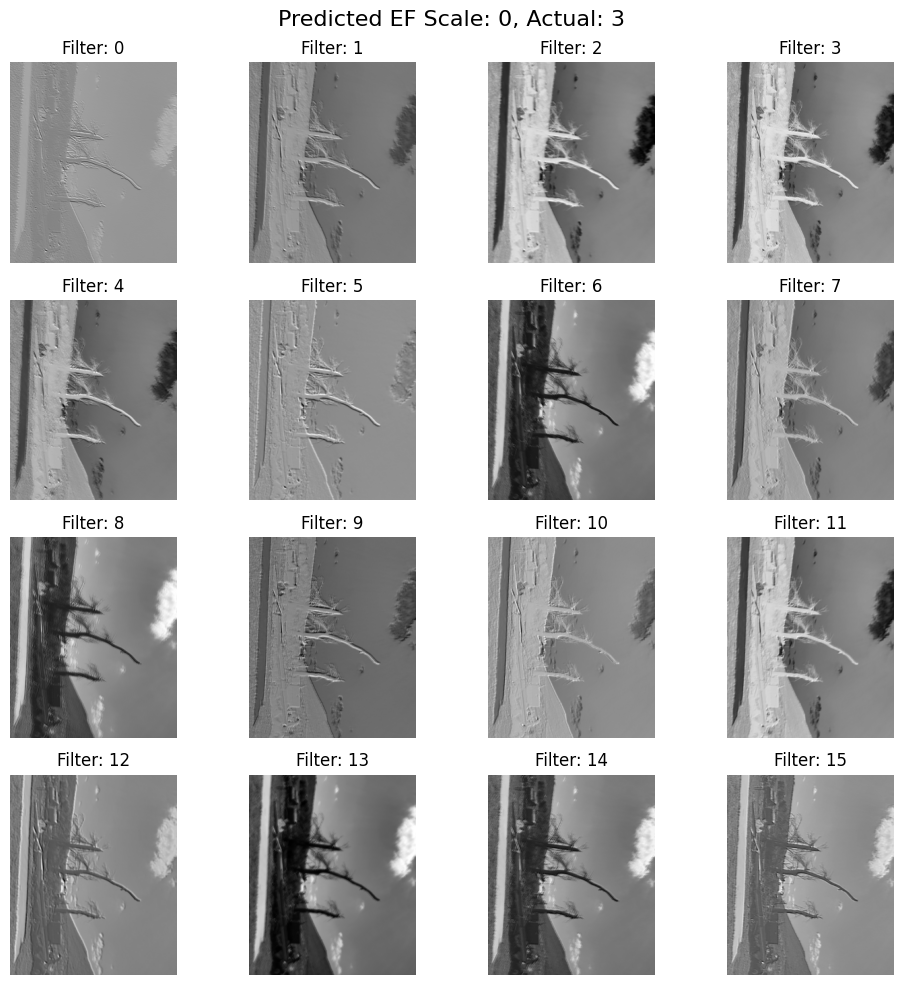

In [249]:
model.cpu()
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None]).detach()
# Get the prediction for the image
with torch.no_grad():
    output = model(im.unsqueeze(0))  
    pred_class = torch.argmax(output, dim=1)  # Predicted class
    actual_class = c  # True label

# If you are using intermediate layer outputs (like filters), rotate them as needed:
num_filters = intermediate_output.shape[1]
rotated_filters = torch.rot90(intermediate_output, k=-1, dims=[2, 3])  # Rotate filters 90 degrees

# Set grid size (e.g., 4x4 for displaying filters)
n = min(4, int(num_filters ** 0.5))  # Choose an appropriate grid size
fig, ax = plt.subplots(n, n, figsize=(10, 10))

for ix, axis in enumerate(ax.flat):
    if ix < num_filters:  # Avoid out-of-bounds indexing
        axis.set_title(f'Filter: {ix}')
        axis.imshow(rotated_filters[0, ix].cpu(), cmap='gray')  # Show the correct filter
        axis.axis('off')

# Show Predicted vs Actual Classes
plt.suptitle(f"Predicted EF Scale: {pred_class.item()}, Actual: {actual_class}", fontsize=16)

plt.tight_layout()
plt.show()

In [255]:
# Assuming 'im' is a single image of shape [channels, height, width]
im = im.unsqueeze(0)  # Add a batch dimension: [1, channels, height, width]

# Ensure 'im' is on the correct device (CPU/GPU)
im = im.cpu()

# Get the output from the first layer of the model
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im).detach()  # Detach to avoid gradient tracking

# Get the prediction for the image
with torch.no_grad():
    output = model(im)  # Forward pass through the entire model
    pred_class = torch.argmax(output, dim=1)  # Predicted class
    actual_class = c  # True label

# If you are using intermediate layer outputs (like filters), rotate them as needed:
num_filters = intermediate_output.shape[1]  # Number of filters
rotated_filters = torch.rot90(intermediate_output, k=-1, dims=[2, 3])  # Rotate filters 90 degrees

# Set grid size (e.g., 4x4 for displaying filters)
n = min(4, int(num_filters ** 0.5))  # Choose an appropriate grid size
fig, ax = plt.subplots(n, n, figsize=(10, 10))

for ix, axis in enumerate(ax.flat):
    if ix < num_filters:  # Avoid out-of-bounds indexing
        axis.set_title(f'Filter: {ix}')
        axis.imshow(rotated_filters[0, ix].cpu(), cmap='gray')  # Show the correct filter
        axis.axis('off')

# Show Predicted vs Actual Classes
plt.suptitle(f"Predicted EF Scale: {pred_class.item()}, Actual: {actual_class.item()}", fontsize=16)

plt.tight_layout()
plt.show()




RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 1, 1, 32, 1, 250, 300]

In [207]:
from torchcam.methods import GradCAM

image, label = next(iter(val_dl))  # Get a batch from your test dataloader
image = image[0].unsqueeze(0).to(device)  # Select first image and move to the device

# Get the class index for the prediction
with torch.no_grad():
    output = model(image)
    pred_class = torch.argmax(output, dim=1)

# Create the GradCAM object
gradcam = GradCAM(model, target_layers=[model.layer4[-1]])  # Specify the target layer (usually the last convolution layer)

# Generate Grad-CAM heatmap
activation_map = gradcam(image.squeeze(0))  # Get the activation map for the selected image

# Normalize the activation map
activation_map = activation_map.squeeze().cpu().numpy()
activation_map -= activation_map.min()
activation_map /= activation_map.max()

# Get the original image and convert it for visualization
image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
image = np.uint8(image * 255)

# Plot the image and Grad-CAM heatmap
plt.figure(figsize=(10, 10))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Original Image - Pred: {pred_class.item()}")
plt.axis("off")

# Grad-CAM Heatmap
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(activation_map, cmap='jet', alpha=0.5)  # Overlay heatmap on the original image
plt.title(f"Grad-CAM - Pred: {pred_class.item()}")
plt.axis("off")

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'torchcam'

In [208]:
pip install torchcam

  Using cached torchcam-0.4.0-py3-none-any.whl.metadata (31 kB)
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + e:\Computer Vision Project\.venv\Scripts\python.exe C:\Users\nicol\AppData\Local\Temp\pip-install-9g4i59vo\numpy_633a0efb67904acdb8e4464c269fb972\vendored-meson\meson\meson.py setup C:\Users\nicol\AppData\Local\Temp\pip-install-9g4i59vo\numpy_633a0efb67904acdb8e4464c269fb972 C:\Users\nicol\AppData\Local\Temp\pip-install-9g4i59vo\numpy_633a0efb67904acdb8e4464c269fb972\.mesonpy-wvq9m0i9 -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\nicol\AppData\Local\Temp\pip-install-9g4i59vo\numpy_633a0efb67904acdb8e4464c269fb972\.mesonpy-wvq9m0i9\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\nicol\AppData\Local\Temp\pip-install-9g4i59vo\numpy_633a0efb67904acdb8e4464c269fb972
      Build dir: C:\Users\nicol\AppData\Local\Temp\pip-install-9g4i59vo\numpy_63

## ResNet18 Model

### Setup

In [99]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 4),
        nn.Sigmoid()
    )

    loss_fn = nn.CrossEntropyLoss()  # Binary Cross-Entropy loss for binary classification
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

# Training batch function
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()  # Reset gradients
    prediction = model(x)  # Forward pass
    batch_loss = loss_fn(prediction, y)  # Compute loss
    batch_loss.backward()  # Backpropagation
    optimizer.step()  # Update model weights
    return batch_loss.item()

# Accuracy function
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()  # Set model to evaluation mode
    prediction = model(x)

    _, predicted_class = torch.max(prediction, 1)

    # Compare predicted class with the true class
    is_correct = (predicted_class == y)  # True if correct class, False otherwise
    return is_correct.float().mean()

# Data loading function
def get_data():
    train = TornadoDataset(df="images.csv", img_dir="Images")
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)

    val = TornadoDataset(df="images.csv", img_dir="Images")
    val_dl = DataLoader(val, batch_size=32, shuffle=False, drop_last=True)

    return trn_dl, val_dl

# Device setup (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize DataLoader and Model
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

e:\Computer Vision Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Computer Vision Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training

In [100]:
# Define the train_batch method for classification
def train_batch(data, model, optimizer, criteria):
    # Specify that we are training the model, reset the optimizer to
    # zero_grad, and calculate the predicted value of the EF scale class
    
    ims, efscale = data  # ims = images, efscale = the label (EF scale)
    model.train()
    optimizer.zero_grad()

    # Forward pass
    pred_efscale = model(ims)  # Model outputs the raw scores (logits)

    # Calculate the loss for EF scale classification
    loss = criteria(pred_efscale, efscale)  # Using CrossEntropyLoss

    # Perform backpropagation and optimization
    loss.backward()
    optimizer.step()
    
    return loss.item()

# Define the validate_batch function for classification
def validate_batch(data, model, criteria):
    # Specify that we want to evaluate the model, and so no gradient
    # calculations are required before predicting the EF scale class
    model.eval()
    ims, efscale = data  # ims = images, efscale = the label (EF scale)
    
    with torch.no_grad():
        # Forward pass
        pred_efscale = model(ims)

    # Calculate the loss value corresponding to EF scale prediction
    loss = criteria(pred_efscale, efscale)  # Using CrossEntropyLoss

    # Predicted class is the one with the highest score
    pred_class = torch.argmax(pred_efscale, dim=1)
    
    # Calculate accuracy
    accuracy = (pred_class == efscale).float().sum()/len(efscale)  # Correct predictions

    return loss.item(), accuracy.item()


In [101]:
train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
    print(f"Epoch {epoch + 1}/5")

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    # Training loop
    for ix, batch in enumerate(iter(trn_dl)):
        ims, efscale = batch
        ims, efscale = ims.to(device), efscale.to(device)  # Move to GPU if available

        # Calculate loss for the batch
        # Update this part where you call train_batch to pass a single loss function instead of a tuple
        batch_loss = train_batch((ims,efscale), model,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)

        # Calculate accuracy for the batch
        is_correct = accuracy(ims, efscale, model)
        train_epoch_accuracies.append(is_correct.item())

    # Calculate average loss and accuracy for the epoch
    train_epoch_loss = np.mean(train_epoch_losses)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    # Validation loop
    for ix, batch in enumerate(iter(val_dl)):
        ims, efscale = batch
        ims, efscale = ims.to(device), efscale.to(device)  # Move to GPU if available

        # Calculate accuracy for the validation batch
        val_loss, val_acc = validate_batch((ims, efscale), model, loss_fn)
        val_epoch_accuracies.append(val_acc)

    # Calculate average validation accuracy
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    # Store the results for each epoch
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Val Accuracy: {val_epoch_accuracy:.4f}")



Epoch 1/5
Train Loss: 1.3270, Train Accuracy: 0.4414
Val Accuracy: 0.4102
Epoch 2/5
Train Loss: 1.2586, Train Accuracy: 0.4570
Val Accuracy: 0.4102
Epoch 3/5
Train Loss: 1.2383, Train Accuracy: 0.4570
Val Accuracy: 0.4102
Epoch 4/5
Train Loss: 1.2129, Train Accuracy: 0.4414
Val Accuracy: 0.4102
Epoch 5/5
Train Loss: 1.2001, Train Accuracy: 0.4453
Val Accuracy: 0.4102


### Assessing Model

C:\Users\nicol\AppData\Local\Temp\ipykernel_68636\197690585.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


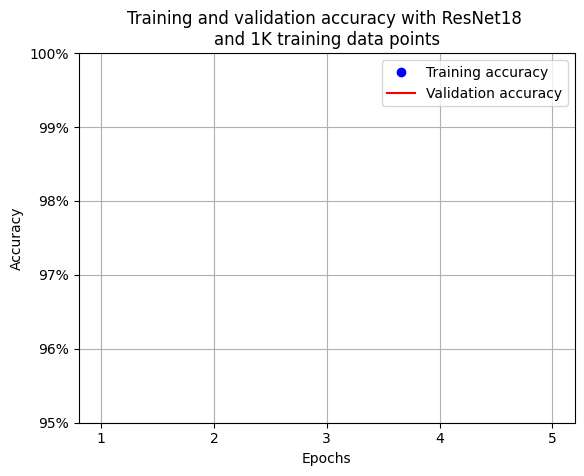

In [102]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [103]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  